### Kokilaraj A. 2020/E/074
### Sathursan P. 2020/E/145

In [2]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10


In [3]:
import ultralytics
import torch
from roboflow import Roboflow
from ultralytics import YOLO
from IPython.display import Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="zzDDVceswMPjjkw54wDh")
project = rf.workspace("fireandsmoke-gjn7t").project("fire_smoke_detection-qudqu")
version = project.version(12)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fire_smoke_detection-12 in yolov11:: 100%|██████████| 2479/2479 [00:00<00:00, 5186.19it/s]


In [5]:
from ultralytics import __version__
print(__version__)

8.3.60


### Dataset visualization

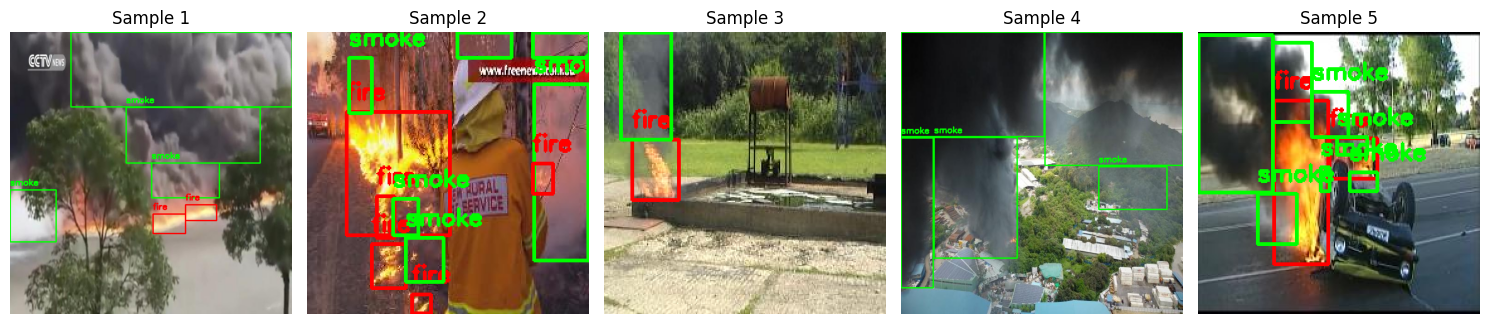

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

images_dir = "/content/fire_smoke_detection-12/train/images"
labels_dir = "/content/fire_smoke_detection-12/train/labels"
classes = ["fire", "smoke"]

def draw_bounding_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        class_id = int(class_id)

        img_h, img_w, _ = image.shape
        x1 = int((x_center - width / 2) * img_w)
        y1 = int((y_center - height / 2) * img_h)
        x2 = int((x_center + width / 2) * img_w)
        y2 = int((y_center + height / 2) * img_h)


        color = (255, 0, 0) if class_id == 0 else (0, 255, 0)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(image, classes[class_id], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return image

num_samples = 5
sample_images = os.listdir(images_dir)[:num_samples]

plt.figure(figsize=(15, 10))
for i, image_name in enumerate(sample_images):
    image_path = os.path.join(images_dir, image_name)
    label_path = os.path.join(labels_dir, image_name.replace(".jpg", ".txt"))

    if os.path.exists(label_path):
        annotated_image = draw_bounding_boxes(image_path, label_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(annotated_image)
        plt.axis("off")
        plt.title(f"Sample {i + 1}")
    else:
        print(f"Label file not found for {image_name}")

plt.tight_layout()
plt.show()

## Label verification

In [7]:
def verify_labels(images_dir, labels_dir):
    for image_name in os.listdir(images_dir):
        image_path = os.path.join(images_dir, image_name)
        label_path = os.path.join(labels_dir, image_name.replace(".jpg", ".txt"))
        if not os.path.exists(label_path):
            print(f"Missing label file for {image_name}")
verify_labels("/content/fire_smoke_detection-12/train/images", "/content/fire_smoke_detection-12/train/labels")

This means there's no label error in this dataset

### Data class distribution checking

In [8]:
import os
from collections import Counter

labels_dir = "/content/fire_smoke_detection-12/train/labels"
class_counts = Counter()

for label_file in os.listdir(labels_dir):
    with open(os.path.join(labels_dir, label_file), "r") as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

print("Class Distribution:", class_counts)

Class Distribution: Counter({1: 1954, 0: 1889})


So accodording to this there's no class biasing in the dataset.

# Model

In [9]:
from ultralytics import __version__
print(__version__)

8.3.60


In [ ]:
!yolo task=detect mode=train model=yolo11s.pt data=/content/fire_smoke_detection-12/data.yaml epochs=50 imgsz=640 plots=True

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/fire_smoke_detection-12/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

In [ ]:
!yolo task=detect mode=val model=/content/runs/detect/train2/weights/best.pt data=/content/fire_smoke_detection-12/data.yaml

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/fire_smoke_detection-12/valid/labels.cache... 315 images, 34 backgrounds, 0 corrupt: 100% 315/315 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 20/20 [00:06<00:00,  3.04it/s]
                   all        315       1096      0.533       0.46      0.476      0.238
                  fire        245        565      0.568      0.566      0.567      0.303
                 smoke        174        531      0.497      0.354      0.384      0.174
Speed: 0.9ms preprocess, 9.1ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [4]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Testing model with fire image


image 1/1 C:\Users\Admin\Desktop\7th semi Labs\Computer vision\Mini project\Fire and smoke detector\fire.jpg: 640x640 1 fire, 186.6ms
Speed: 3.0ms preprocess, 186.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


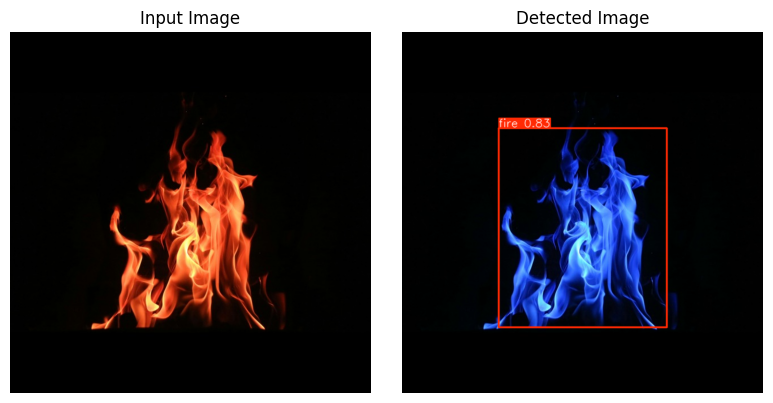

In [12]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

model = YOLO('C:/Users/Admin/Desktop/7th semi Labs/Computer vision/Mini project/Fire and smoke detector/Fire_and_smoke_detector/Fire_and_smoke_detector.pt')

input_image_path = 'C:/Users/Admin/Desktop/7th semi Labs/Computer vision/Mini project/Fire and smoke detector/fire.jpg'

results = model.predict(source=input_image_path, imgsz=640, conf=0.4)

input_image = cv2.imread(input_image_path)[..., ::-1]
annotated_image = results[0].plot()

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(input_image)
axes[0].axis('off')
axes[0].set_title("Input Image")
axes[1].imshow(annotated_image)
axes[1].axis('off')
axes[1].set_title("Detected Image")
plt.tight_layout()
plt.show()

## Run the real-time detection

In [ ]:
from ultralytics import YOLO

model = YOLO('C:/Users/Admin/Desktop/7th semi Labs/Computer vision/Mini project/Fire and smoke detector/Fire_and_smoke_detector/Fire_and_smoke_detector.pt')
model.predict(source=0, imgsz=640, conf = 0.4, show=True)